In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import yeojohnson
from scipy.special import boxcox1p

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from prettytable import PrettyTable
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
df = pd.read_csv('attributes_spotify.csv')
df.drop(df.columns[0], axis = 1, inplace = True)
# df.head()
df.describe()
# df.apply('skew')

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In [3]:
report = ProfileReport(df)
report.to_file('report.html') 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# drop dulpicates
df.drop_duplicates(inplace = True) 
df.count() 
# determine missing values
# df.isnull().sum()
# df['time_signature'].value_counts()

acousticness        2012
danceability        2012
duration_ms         2012
energy              2012
instrumentalness    2012
key                 2012
liveness            2012
loudness            2012
mode                2012
speechiness         2012
tempo               2012
time_signature      2012
valence             2012
target              2012
song_title          2012
artist              2012
dtype: int64

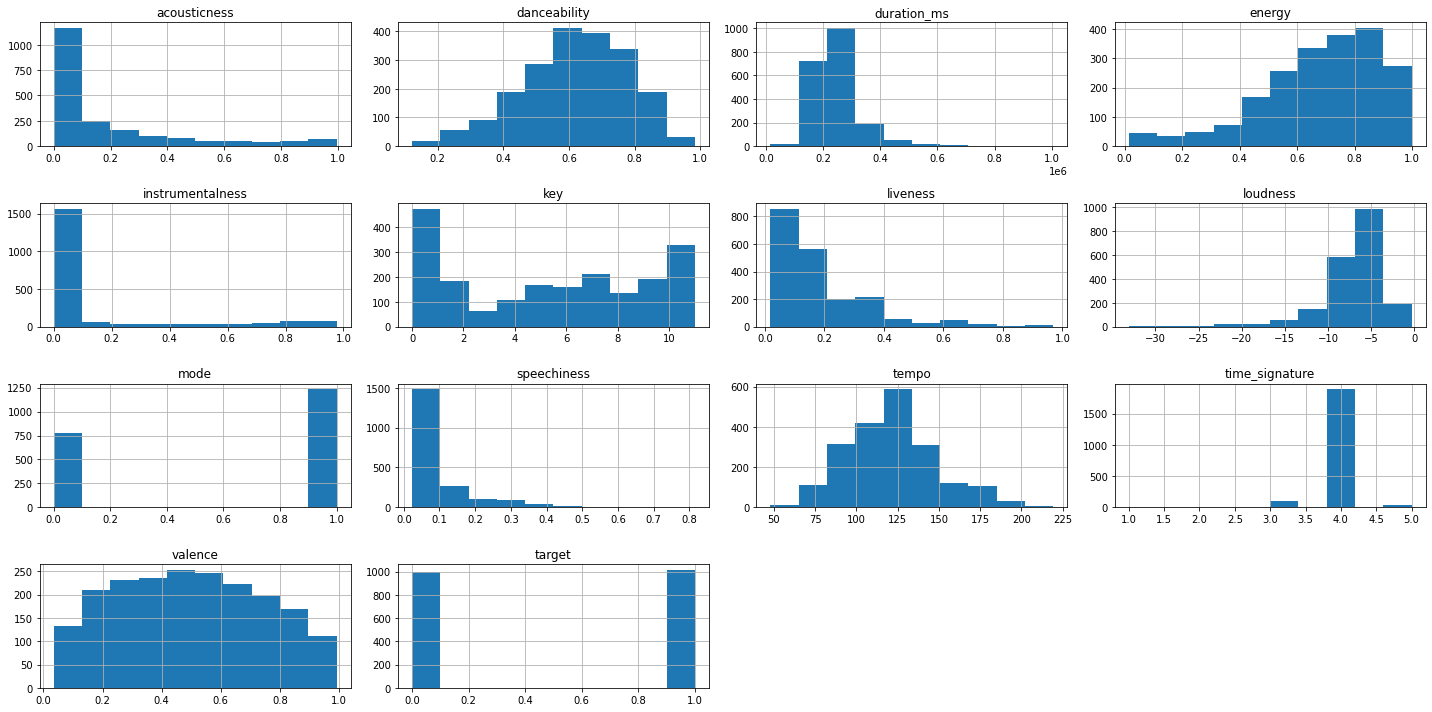

In [5]:
df.hist(figsize=(20, 10))
plt.tight_layout()
# plt.savefig('hist.png')

In [6]:
# re-type categorical features as categorical
for col in ['key', 'mode', 'time_signature']:
    df[col] = df[col].astype('category')
df.dtypes 

acousticness         float64
danceability         float64
duration_ms            int64
energy               float64
instrumentalness     float64
key                 category
liveness             float64
loudness             float64
mode                category
speechiness          float64
tempo                float64
time_signature      category
valence              float64
target                 int64
song_title            object
artist                object
dtype: object

In [7]:
# create a table to track skew for each transformation
skewtable = PrettyTable()
skewtable.field_names = ['Treatment', 'acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']
skewtable.add_row(['no treatment', df['acousticness'].apply('skew'), df['duration_ms'].apply('skew'), df['energy'].apply('skew'), df['instrumentalness'].apply('skew'), df['liveness'].apply('skew'), df['loudness'].apply('skew'), df['speechiness'].apply('skew')])
# # df.apply('skew')
# skewtable

In [8]:
# skew transformation - natural log
dfTemp = df.copy()

for col in ['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'speechiness']:
    dfTemp[col] = df[col].apply(np.log)
skewtable.add_row(['ln', dfTemp['acousticness'].apply('skew'), dfTemp['duration_ms'].apply('skew'), dfTemp['energy'].apply('skew'), dfTemp['instrumentalness'].apply('skew'), dfTemp['liveness'].apply('skew'), dfTemp['loudness'].apply('skew'), dfTemp['speechiness'].apply('skew')])

In [9]:
# skew transformation - square root
dfTemp = df.copy()

for col in ['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']:
    dfTemp[col] = df[col].apply(np.sqrt)
skewtable.add_row(['square root', dfTemp['acousticness'].apply('skew'), dfTemp['duration_ms'].apply('skew'), dfTemp['energy'].apply('skew'), dfTemp['instrumentalness'].apply('skew'), dfTemp['liveness'].apply('skew'), dfTemp['loudness'].apply('skew'), dfTemp['speechiness'].apply('skew')])

In [10]:
# skew transformation - log base 10
dfTemp = df.copy()

for col in ['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']:
    dfTemp[col] = df[col].apply(np.log10)
skewtable.add_row(['log10', dfTemp['acousticness'].apply('skew'), dfTemp['duration_ms'].apply('skew'), dfTemp['energy'].apply('skew'), dfTemp['instrumentalness'].apply('skew'), dfTemp['liveness'].apply('skew'), dfTemp['loudness'].apply('skew'), dfTemp['speechiness'].apply('skew')])

In [11]:
# skew transformation - boxcox
dfTemp = df.copy()

for col in ['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'speechiness']:
    dfTemp[col] = df[col].apply(lambda x: boxcox1p(x, 0.25))
skewtable.add_row(['boxcox', dfTemp['acousticness'].apply('skew'), dfTemp['duration_ms'].apply('skew'), dfTemp['energy'].apply('skew'), dfTemp['instrumentalness'].apply('skew'), dfTemp['liveness'].apply('skew'), 'nan', dfTemp['speechiness'].apply('skew')])

In [12]:
# skew transformation - yeo-johnson
dfTemp = df.copy()

for col in ['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']:
    dfTemp[col], lam = yeojohnson(df[col])
skewtable.add_row(['yeo-johnson', dfTemp['acousticness'].apply('skew'), dfTemp['duration_ms'].apply('skew'), dfTemp['energy'].apply('skew'), dfTemp['instrumentalness'].apply('skew'), dfTemp['liveness'].apply('skew'), dfTemp['loudness'].apply('skew'), dfTemp['speechiness'].apply('skew')])

In [13]:
skewtable

Treatment,acousticness,duration_ms,energy,instrumentalness,liveness,loudness,speechiness
no treatment,1.657752997170136,2.5015976606981494,-0.915368942777439,1.957087648568127,1.953186167674238,-2.23592516899075,2.3051674063691268
ln,-1.013839550743309,-0.3267710154721611,-3.1976915576066305,nan,0.43480418836962265,-2.23592516899075,0.8454901078765978
square root,0.8250444531167547,1.2845405536680032,-1.7100250130532801,1.5187140591483155,1.1829855461612813,nan,1.491013969019709
log10,-1.0138395507433078,-0.3267710154721725,-3.19769155760663,nan,0.4348041883696231,nan,0.8454901078765981
boxcox,1.45594554787818,0.609362249132055,-1.2031285365852415,1.863050387454074,1.6854166582765264,nan,2.095178641374426
yeo-johnson,0.5125992527413857,0.062129437995162705,-0.14519329454097873,1.2557060807567988,0.32838443315573873,0.0245250248967536,0.5554443248375951


In [14]:
for col in ['acousticness', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness']:
    df[col], lam = yeojohnson(df[col])
df.apply('skew')

acousticness        0.512599
danceability       -0.422987
duration_ms         0.062129
energy             -0.145193
instrumentalness    1.255706
liveness            0.328384
loudness            0.024525
speechiness         0.555444
tempo               0.440990
valence             0.076381
target             -0.017907
dtype: float64

<AxesSubplot:xlabel='target', ylabel='valence'>

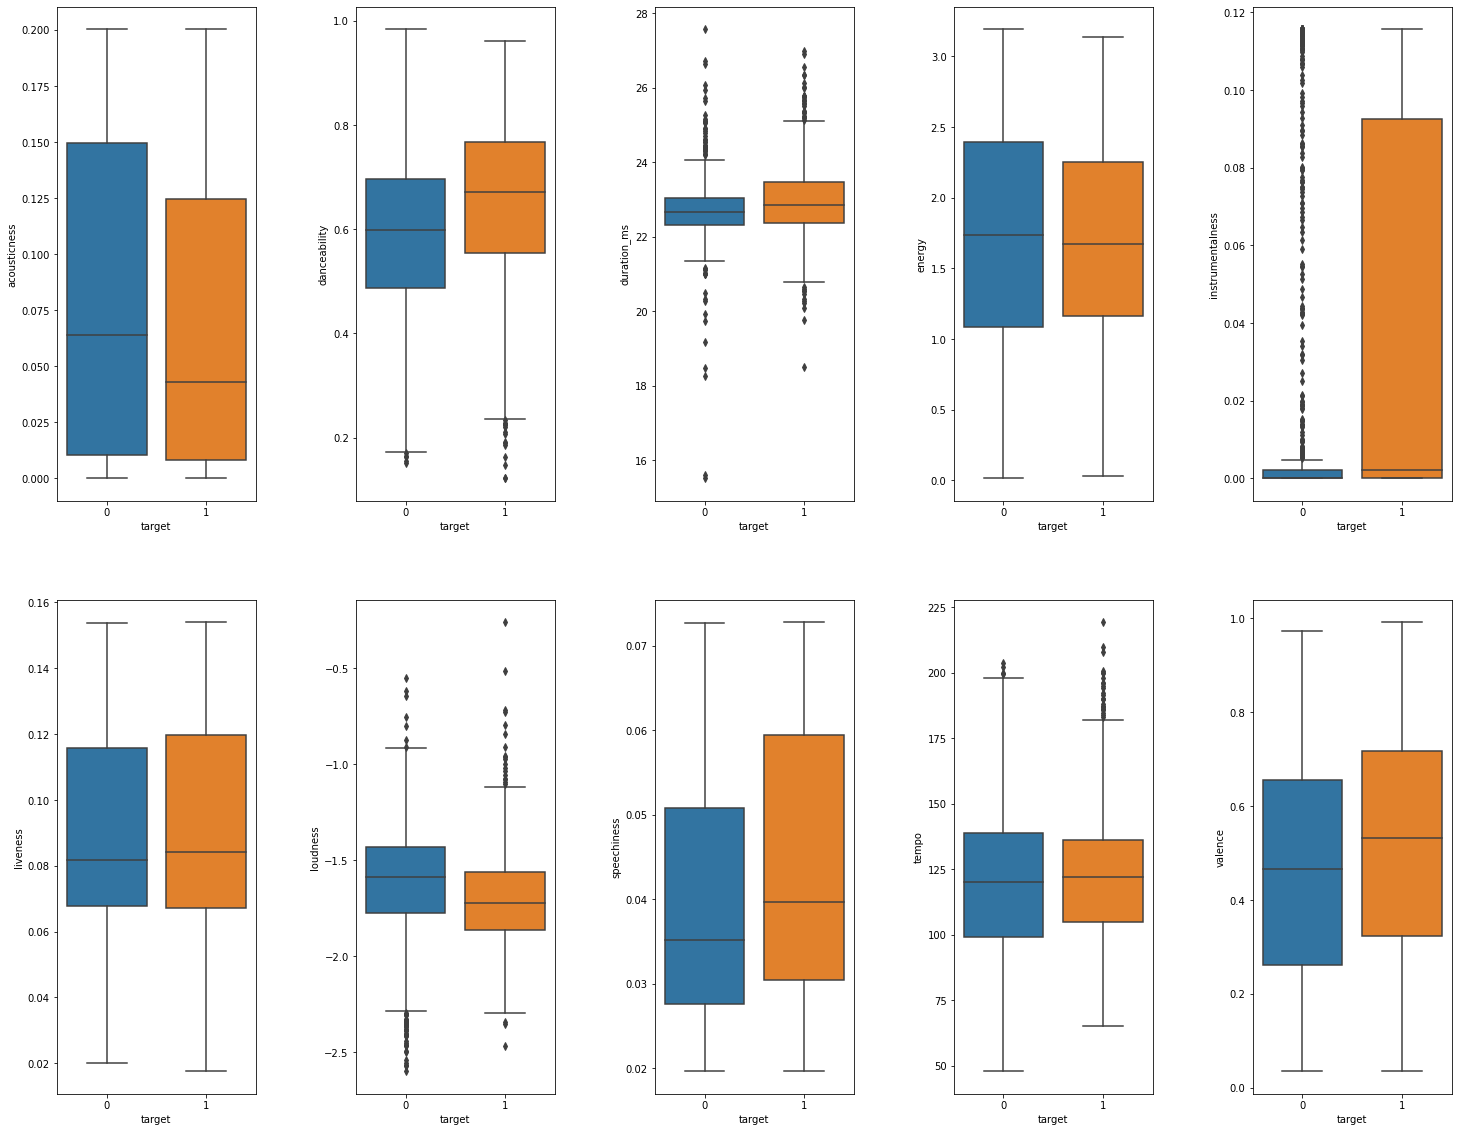

In [15]:
# boxplot
fig, ax = plt.subplots(2,5, figsize = (25,20))
fig.subplots_adjust(wspace = 0.5)
sns.boxplot(ax=ax[0,0], data = df, y = 'acousticness', x = 'target')
sns.boxplot(ax=ax[0,1], data = df, y = 'danceability', x = 'target')
sns.boxplot(ax=ax[0,2], data = df, y = 'duration_ms', x = 'target')
sns.boxplot(ax=ax[0,3], data = df, y = 'energy', x = 'target')
sns.boxplot(ax=ax[0,4], data = df, y = 'instrumentalness', x = 'target')
sns.boxplot(ax=ax[1,0], data = df, y = 'liveness', x = 'target')
sns.boxplot(ax=ax[1,1], data = df, y = 'loudness', x = 'target')
sns.boxplot(ax=ax[1,2], data = df, y = 'speechiness', x = 'target')
sns.boxplot(ax=ax[1,3], data = df, y = 'tempo', x = 'target')
sns.boxplot(ax=ax[1,4], data = df, y = 'valence', x = 'target')
# fig.savefig('box.png')

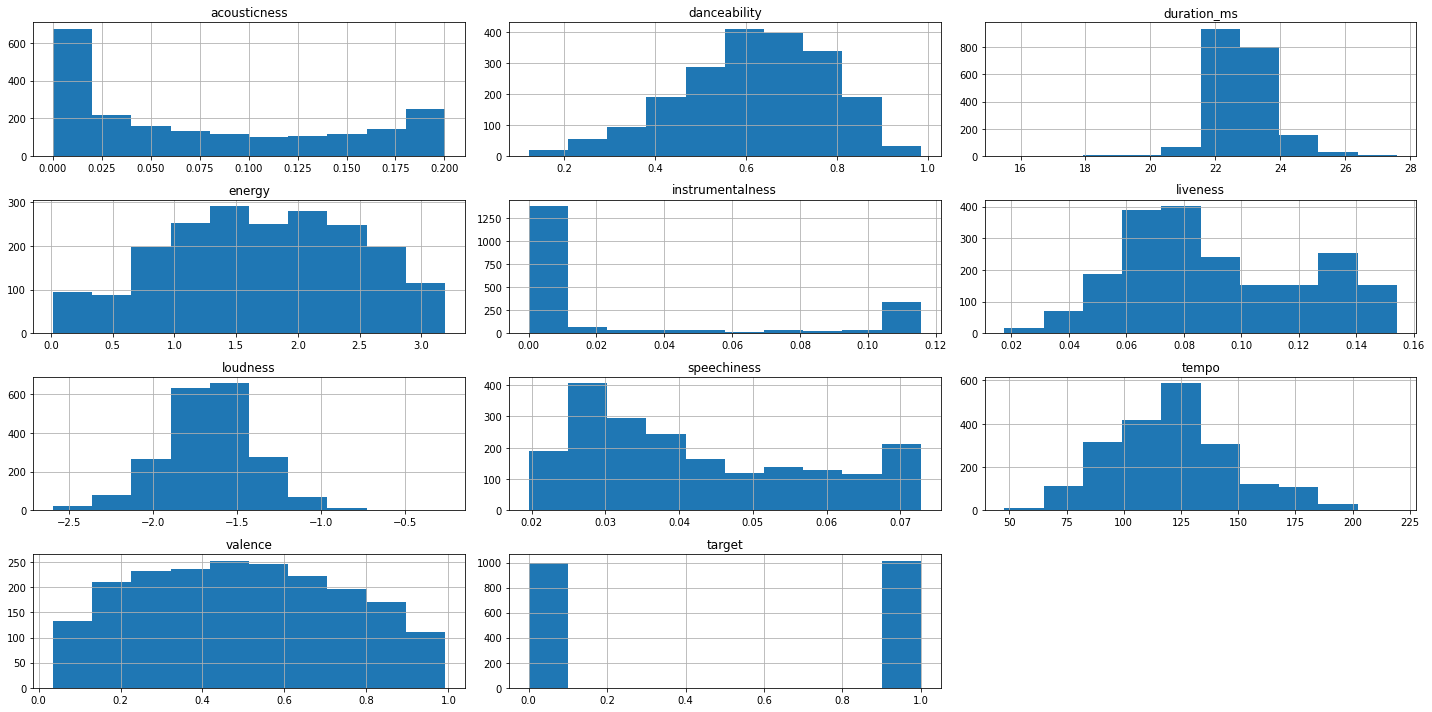

In [16]:
# histograms after skew transformations
df.hist(figsize=(20, 10))
plt.tight_layout()
# plt.savefig('hist2.png')

<Figure size 1800x1800 with 0 Axes>

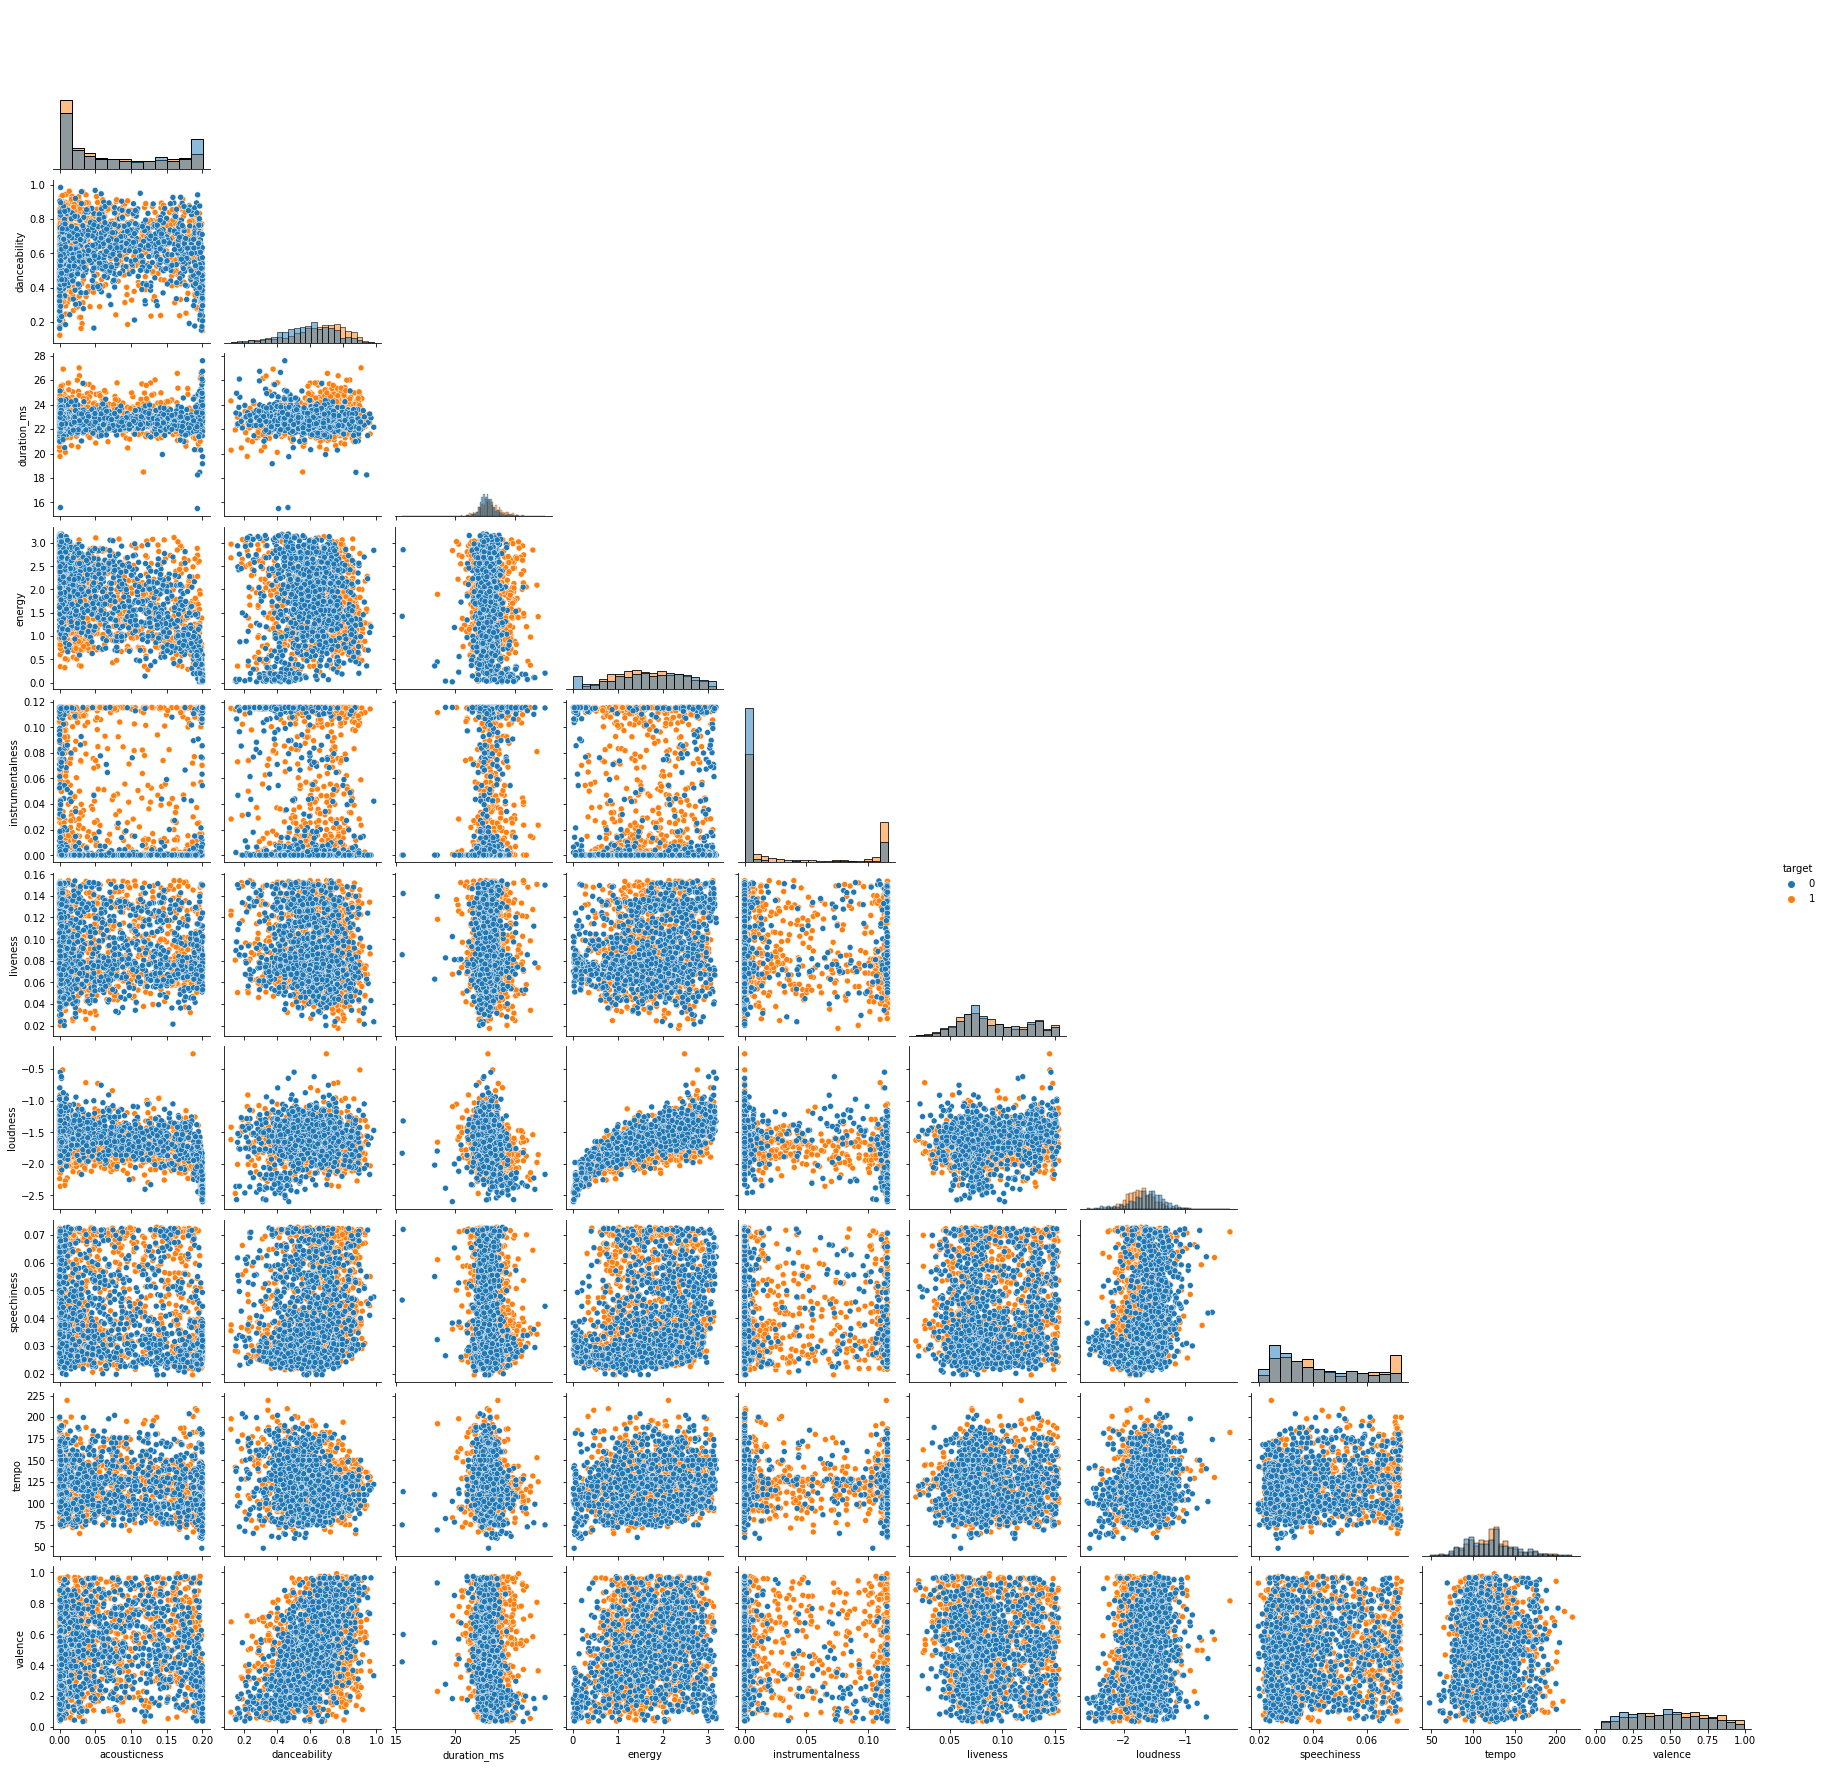

In [17]:
# pairplot
plt.figure(figsize = (25,25))
sns.pairplot(df, hue = 'target', diag_kind = 'hist', corner = True)#.savefig('plot.png')

<AxesSubplot:>

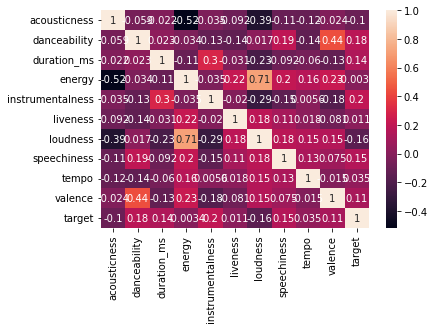

In [18]:
# heatmap
sns.heatmap(df.corr(), annot = True)

In [19]:
# investigate outliers
# dfQ = df. drop(['song_title', 'artist', 'target', 'mode', 'key', 'time_signature'], axis = 1)
# Q1 = df.quantile(0.25)
# Q3 = df.quantile(0.75)
# IQR = Q3 - Q1

# ((dfQ < (Q1 - 1.5 * IQR)) | (dfQ > (Q3 + 1.5 * IQR))).sum()

In [20]:
# investigate outliers - drop top and bottom half percent
# upper = dfQ.quantile(0.095)
# lower = dfQ.quantile(0.005)

# dfQ2 = dfQ[(dfQ < upper) | (dfQ > lower)]
# # df = df[(df < upper)]
# dfQ2.head()


In [21]:
# investigate outliers - see how much data is dropped
# dfQ2.dropna(inplace = True)
# dfQ2.count()

In [22]:
# create train and test sets
X = df.drop(['target', 'song_title', 'artist', 'time_signature'], axis = 1) 

# X = df.drop(['target', 'song_title', 'artist', 'time_signature', 'key'], axis = 1) 
X = pd.get_dummies(X, columns = ['key']) # comment out to run w/o key

y = df['target']
x_train_unscaled, x_test_unscaled, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 8)
# scale the data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train_unscaled)
x_test = scaler.transform(x_test_unscaled)

In [23]:
# KNN - build and tune
ks = [i for i in range(1, 50)]
scores = []
for i in ks:
    knn = KNeighborsClassifier(n_neighbors = i)
    score = cross_val_score(knn, x_train, y_train, cv = 5)
    scores.append(np.mean(score))

best_k = ks[np.argmax(scores)]
print(best_k)

11


[Text(0.5, 1.0, 'Scores by K-value')]

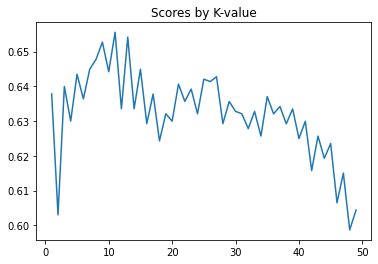

In [24]:
# KNN - plot of k value v scores
sns.lineplot(x = ks, y = scores).set(title = 'Scores by K-value')

In [25]:
# KNN - fit and train best model
best_knn = KNeighborsClassifier(n_neighbors = best_k)
y_pred = best_knn.fit(x_train, y_train).predict(x_test)
y_pred_train = best_knn.predict(x_train)

In [26]:
# KNN - evaluation metrics
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.6688741721854304
train accuracy:  0.7329545454545454
recall:  0.5786163522012578
precision:  0.736
F1 score 0.6478873239436619


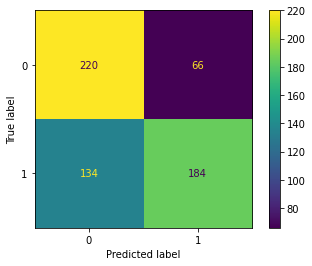

In [27]:
# KNN - plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
mat = ConfusionMatrixDisplay(confusion_matrix=cm)
mat.plot()

In [28]:
# KNN - store stats
pt = PrettyTable()
pt.field_names = ['Model', 'Best Params','Confustion Matrix', "Accuracy", 'Accuraccy (training)', 'Precision', 'Recall', 'F1 Score']
pt.add_row(['KNN', best_k, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])

In [29]:
# random forest - untuned model
rf = RandomForestClassifier() 
y_pred = rf.fit(x_train, y_train).predict(x_test)

In [30]:
# random forest - untuned evaluation metrics
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.8013245033112583
0.8214285714285714
0.7955974842767296
0.8083067092651758


In [31]:
# random forest - hyperparameter tuning
param_grid = {'n_estimators': [i for i in range(1,200,7)], 'max_depth': [i for i in range(1,10)], 'max_features': ['sqrt', 'log2', None]}

rf_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3)
rf_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [1, 8, 15, 22, 29, 36, 43, 50, 57, 64,
                                          71, 78, 85, 92, 99, 106, 113, 120,
                                          127, 134, 141, 148, 155, 162, 169,
                                          176, 183, 190, 197]})

In [32]:
# random forest - best model 
best_rf = rf_search.best_estimator_
print(best_rf)

RandomForestClassifier(max_depth=8, max_features=None, n_estimators=176)


In [33]:
# random forest - fit best model and generate evaluation metrics
y_pred = best_rf.predict(x_test)
y_pred_train = best_rf.predict(x_train)
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.7615894039735099
train accuracy:  0.9261363636363636
recall:  0.7547169811320755
precision:  0.7843137254901961
F1 score 0.7692307692307692


In [34]:
# random forest - store stats
pt.add_row(['Random Forest', best_rf, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])
# print(pt)

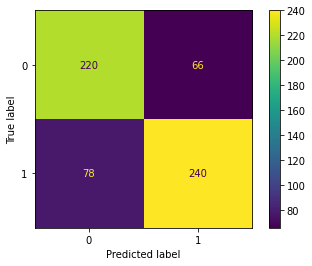

In [35]:
# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
mat = ConfusionMatrixDisplay(confusion_matrix=cm)
mat.plot()

<AxesSubplot:title={'center':'Feature Importance - Random Forest'}>

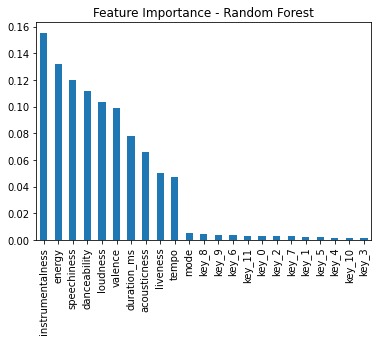

In [36]:
# random forest - feature importantance visual 
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances.plot(kind = 'bar', title = 'Feature Importance - Random Forest')

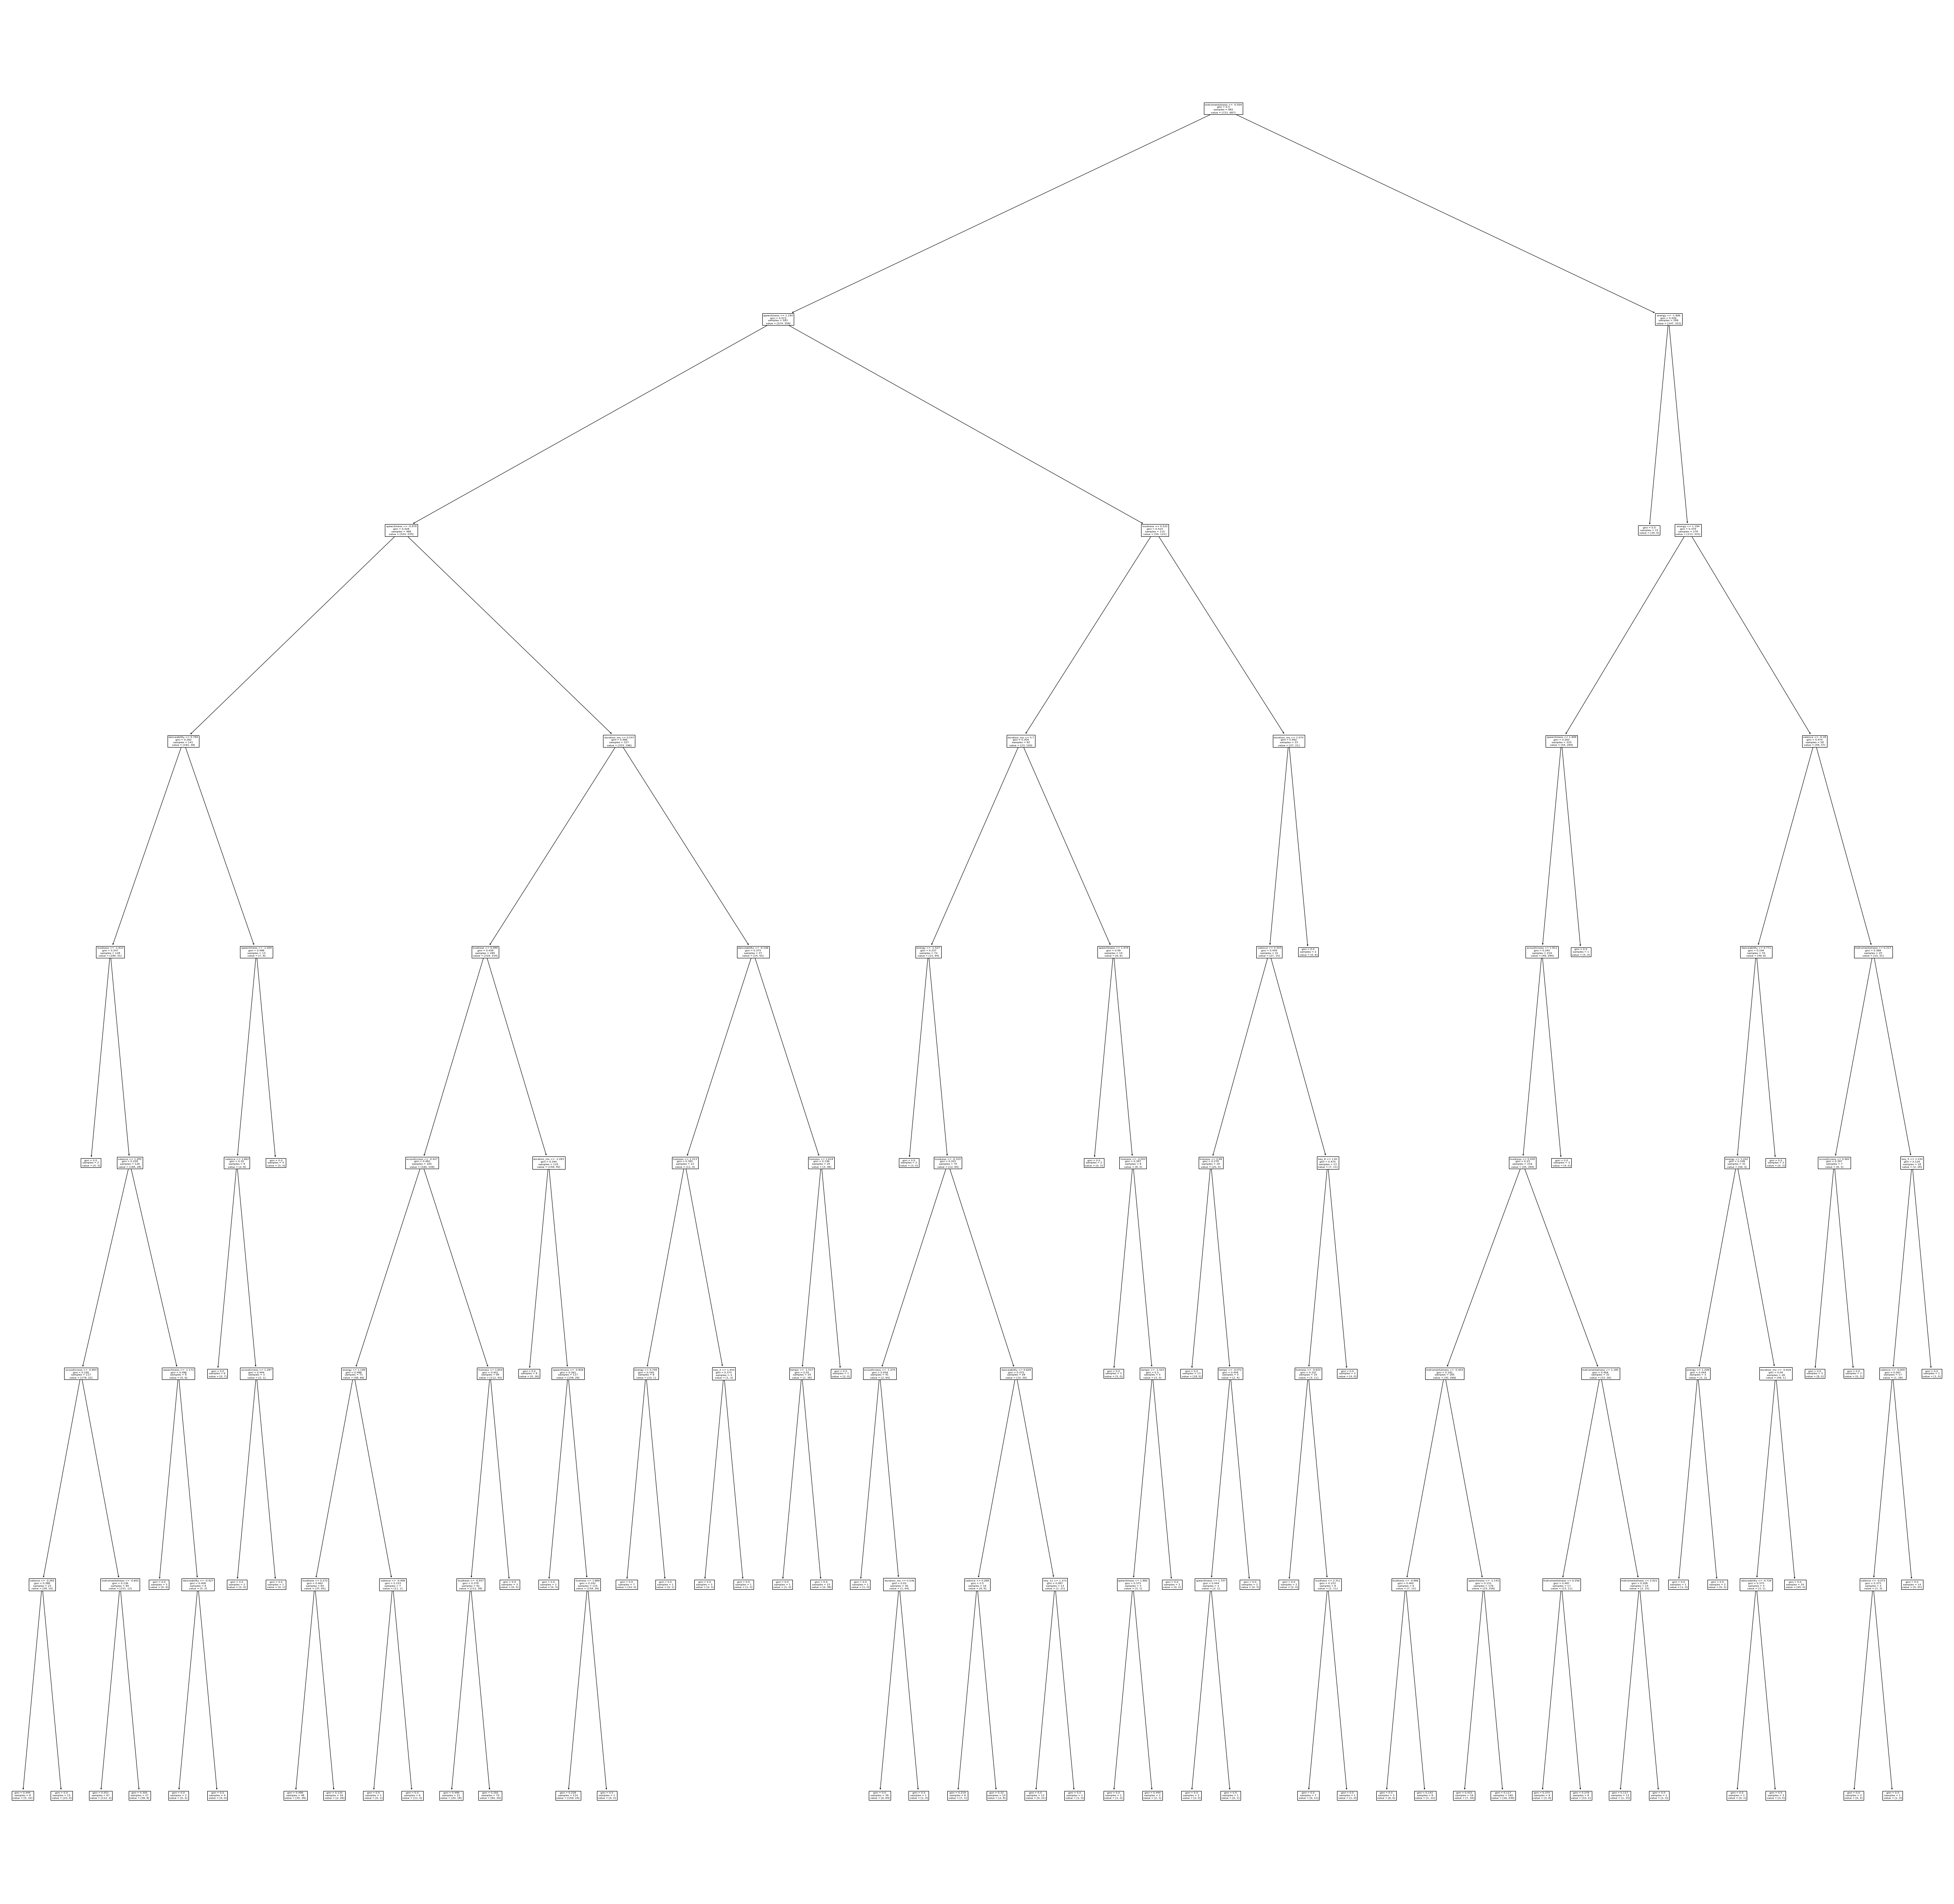

In [37]:
# random forest - plot a tree
plt.figure(figsize = (80,80))
_ = tree.plot_tree(best_rf.estimators_[8], feature_names = X.columns)
# plt.savefig('tree.png')

In [38]:
# SVM - untuned model
svm = SVC()
y_pred = svm.fit(x_train, y_train).predict(x_test)

In [39]:
# SVM - untuned evaluation metrics
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.7483443708609272
0.8007246376811594
0.6949685534591195
0.7441077441077442


In [40]:
# SVM - hyperparameter tuning

param_grid = {'kernel': ['linear', 'poly', 'rbf'], 'C': [0.1, 1.0, 10, 100], 'gamma': [1, 10, 100]}

# when running w/o keys, use below param_grid - took hours when the poly kernel was included
# param_grid = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1.0, 10, 100], 'gamma': [1, 10, 100]}

svm_search = GridSearchCV(svm, param_grid = param_grid, cv = 3)
svm_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1.0, 10, 100], 'gamma': [1, 10, 100],
                         'kernel': ['linear', 'poly', 'rbf']})

In [41]:
# SVM - best model
best_svm = svm_search.best_estimator_
print(best_svm)
# best_svm.get_params()

SVC(C=10, gamma=1, kernel='linear')


Text(0.5, 1.0, 'Feature Importance - SVM')

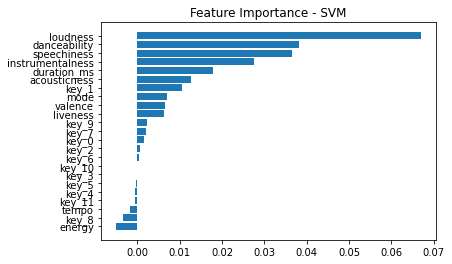

In [42]:
# SVM - feature importance
feat_import = permutation_importance(best_svm, x_test, y_test)
feats = np.array(X.columns)
idx_sort = feat_import.importances_mean.argsort()
plt.barh(feats[idx_sort], feat_import.importances_mean[idx_sort])
plt.title('Feature Importance - SVM')

In [43]:
# SVM - fit best model and evaluation metrics
y_pred = best_svm.predict(x_test)
y_pred_train = best_svm.predict(x_train)
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.695364238410596
train accuracy:  0.6917613636363636
recall:  0.6635220125786163
precision:  0.7326388888888888
F1 score 0.6963696369636964


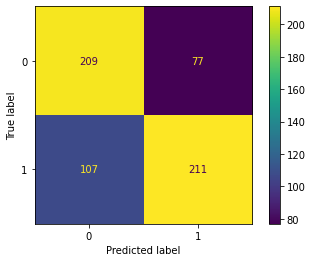

In [44]:
# SVM - plot confustion matrix
cm = confusion_matrix(y_test, y_pred)
mat = ConfusionMatrixDisplay(confusion_matrix=cm)
mat.plot()

In [45]:
# SVM - store stats
pt.add_row(['SVM', best_svm, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])

In [46]:
# logistic regression - untuned model
lr = LogisticRegression() 
y_pred = lr.fit(x_train, y_train).predict(x_test)

In [47]:
# logistic regression - untuned evaluation metrics
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6986754966887417
0.7344827586206897
0.6698113207547169
0.7006578947368421


In [48]:
# logistic regression - hyperparameter tuning
param_grid = {'penalty': ['l1','l2'], 'C': [0.1, 1.0, 10, 100], 'solver': ['liblinear', 'lbfgs']}

lr_search = GridSearchCV(lr, param_grid = param_grid, cv = 3)
lr_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1.0, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']})

In [49]:
# logistic regression - best model
best_lr = lr_search.best_estimator_
print(best_lr)
# best_svm.get_params()

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')


In [50]:
# logistic regression - fit best model and evaluation metrics
y_pred_train = best_lr.predict(x_train)
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.6986754966887417
train accuracy:  0.6775568181818182
recall:  0.6698113207547169
precision:  0.7344827586206897
F1 score 0.7006578947368421


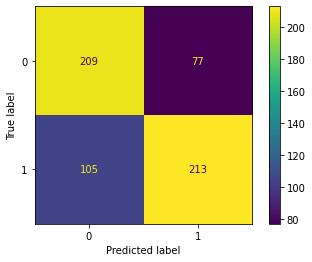

In [51]:
# logistic regression - plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
mat = ConfusionMatrixDisplay(confusion_matrix=cm)
mat.plot()

In [52]:
#logistic regression - store stats
pt.add_row(['Logistic Regression', best_lr, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])

In [53]:
# stochastic graident descent - untuned model - hinge
sgdHinge = SGDClassifier(loss = 'hinge')
y_pred = sgdHinge.fit(x_train, y_train).predict(x_test)

In [54]:
# SGD - hinge - untuned evaluation metrics
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6456953642384106
0.6733333333333333
0.6352201257861635
0.6537216828478963


In [55]:
# SGD - hyperparameter tuning - hinge
param_grid = { "alpha" : [0.0001, 0.001, 0.01, 0.1], "penalty" : ["l2", "l1", "elasticnet", "none"]}

sgdHinge_search = GridSearchCV(sgdHinge, param_grid = param_grid, cv = 3)
sgdHinge_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SGDClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'penalty': ['l2', 'l1', 'elasticnet', 'none']})

In [56]:
# SGD - best model - hinge
best_sgdHinge = sgdHinge_search.best_estimator_
print(best_sgdHinge)
# best_sgd.get_params()

SGDClassifier(alpha=0.01, penalty='l1')


In [57]:
#SGD - fit best model and evaluation metrics - hinge
y_pred_train = best_sgdHinge.predict(x_train)
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.6456953642384106
train accuracy:  0.6875
recall:  0.6352201257861635
precision:  0.6733333333333333
F1 score 0.6537216828478963


In [58]:
# SGD - store stats - hinge
pt.add_row(['SGD - hinge loss', best_sgdHinge, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])

In [59]:
# stochastic graident descent - untuned model - huber
sgdHuber = SGDClassifier(loss = 'modified_huber')
y_pred = sgdHuber.fit(x_train, y_train).predict(x_test)

In [60]:
# SGD - untuned evaluation metrics - huber
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6357615894039735
0.6384180790960452
0.710691823899371
0.6726190476190477


In [61]:
# SGD - hyperparameter tuning - huber
# same param grid as above
sgdHuber_search = GridSearchCV(sgdHuber, param_grid = param_grid, cv = 3)
sgdHuber_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SGDClassifier(loss='modified_huber'),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'penalty': ['l2', 'l1', 'elasticnet', 'none']})

In [62]:
# SGD - best model - huber
best_sgdHuber = sgdHuber_search.best_estimator_
print(best_sgdHuber)
# best_sgd.get_params()

SGDClassifier(alpha=0.1, loss='modified_huber', penalty='elasticnet')


In [63]:
#SGD - fit best model and evaluation metrics -huber
y_pred_train = best_sgdHuber.predict(x_train)
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.6357615894039735
train accuracy:  0.6761363636363636
recall:  0.710691823899371
precision:  0.6384180790960452
F1 score 0.6726190476190477


In [64]:
# SGD - store stats - huber
pt.add_row(['SGD - modified_huber loss', best_sgdHuber, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])

In [65]:
# stochastic graident descent - untuned model - log loss
sgdLog = SGDClassifier(loss = 'log_loss')
y_pred = sgdLog.fit(x_train, y_train).predict(x_test)

In [66]:
# SGD - untuned evaluation metrics - log loss
print(accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(f1_score(y_test, y_pred))

0.6440397350993378
0.66996699669967
0.6383647798742138
0.6537842190016103


In [67]:
# SGD - hyperparameter tuning - log loss
# same param grid as above

sgdLog_search = GridSearchCV(sgdLog, param_grid = param_grid, cv = 3)
sgdLog_search.fit(x_train, y_train)

GridSearchCV(cv=3, estimator=SGDClassifier(loss='log_loss'),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'penalty': ['l2', 'l1', 'elasticnet', 'none']})

In [68]:
# SGD - best model - log loss
best_sgdLog = sgdLog_search.best_estimator_
print(best_sgdLog)
# best_sgd.get_params()

SGDClassifier(alpha=0.01, loss='log_loss', penalty='l1')


In [69]:
#SGD - fit best model and evaluation metrics - log loss
y_pred_train = best_sgdLog.predict(x_train)
print('test accuracy: ',  accuracy_score(y_test, y_pred))
print('train accuracy: ',  accuracy_score(y_train, y_pred_train))
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('F1 score', f1_score(y_test, y_pred))

test accuracy:  0.6440397350993378
train accuracy:  0.6796875
recall:  0.6383647798742138
precision:  0.66996699669967
F1 score 0.6537842190016103


In [70]:
# SGD - store stats - log loss
pt.add_row(['SGD - log loss', best_sgdLog, confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred), accuracy_score(y_train, y_pred_train), precision_score(y_test, y_pred), recall_score(y_test, y_pred), f1_score(y_test, y_pred)])

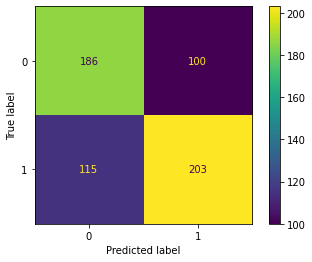

In [71]:
# SGD - plot confusion matrix - best model overall - Log loss
cm = confusion_matrix(y_test, y_pred)
mat = ConfusionMatrixDisplay(confusion_matrix=cm)
mat.plot()

In [72]:
# show all stats
pt

Model,Best Params,Confustion Matrix,Accuracy,Accuraccy (training),Precision,Recall,F1 Score
KNN,11,[[220 66] [134 184]],0.6688741721854304,0.7329545454545454,0.736,0.5786163522012578,0.6478873239436619
Random Forest,"RandomForestClassifier(max_depth=8, max_features=None, n_estimators=176)",[[220 66] [ 78 240]],0.7615894039735099,0.9261363636363636,0.7843137254901961,0.7547169811320755,0.7692307692307692
SVM,"SVC(C=10, gamma=1, kernel='linear')",[[209 77] [107 211]],0.695364238410596,0.6917613636363636,0.7326388888888888,0.6635220125786163,0.6963696369636964
Logistic Regression,"LogisticRegression(C=0.1, penalty='l1', solver='liblinear')",[[209 77] [105 213]],0.6986754966887417,0.6775568181818182,0.7344827586206897,0.6698113207547169,0.7006578947368421
SGD - hinge loss,"SGDClassifier(alpha=0.01, penalty='l1')",[[188 98] [116 202]],0.6456953642384106,0.6875,0.6733333333333333,0.6352201257861635,0.6537216828478963
SGD - modified_huber loss,"SGDClassifier(alpha=0.1, loss='modified_huber', penalty='elasticnet')",[[158 128] [ 92 226]],0.6357615894039735,0.6761363636363636,0.6384180790960452,0.710691823899371,0.6726190476190477
SGD - log loss,"SGDClassifier(alpha=0.01, loss='log_loss', penalty='l1')",[[186 100] [115 203]],0.6440397350993378,0.6796875,0.66996699669967,0.6383647798742138,0.6537842190016103
